In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from biom import load_table
import matplotlib.pyplot as plt
import seaborn as sns
#from gneiss.util import match
from scipy.spatial import KDTree
from scipy.stats import rankdata
from skbio.stats.composition import clr, clr_inv, centralize
from sklearn.neighbors import NearestNeighbors, KDTree
from skbio.stats.ordination import OrdinationResults
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr

from matplotlib import rc
import matplotlib
%matplotlib inline

In [2]:
!ls ../results/results_lr_1e-5_in_0.01_out_0.01

U.txt
Ubias.txt
V.txt
Vbias.txt
latent_dim_1_input_prior_0.01_output_prior_0.01_beta1_0.85_beta2_0.90
model_results.csv
otu_cv_results.csv
params.txt
ranks.csv


In [3]:
!ls ../results

all_microbe_metabolite_interactions.png microcoleus_metabolites.png
bacilus_sp_1_metabolites.png            microcoleus_proportions.png
bacilus_sp_2_metabolites.png            results_lr_1e-5_in_0.01_out_0.01


In [4]:
!ls /Users/mortonjt/Dropbox/UCSD/research/multiomics/soils/results/results_lr_1e-5_in_0.01_out_0.01

ls: /Users/mortonjt/Dropbox/UCSD/research/multiomics/soils/results/results_lr_1e-5_in_0.01_out_0.01: No such file or directory


In [5]:
summary_dir = ('/Users/mortonjt/Dropbox/UCSD/research/multiomics/soils/results'
               'results_lr_1e-5_in_0.01_out_0.01')
fname = os.path.join(summary_dir, 'model.ckpt-3729909.meta') 

In [6]:
coefs = pd.read_csv('../results/results_lr_1e-5_in_0.01_out_0.01/ranks.csv', index_col=0)

In [7]:
from skbio.stats.composition import clr, clr_inv, centralize
hm = pd.DataFrame(clr(centralize(coefs.apply(clr_inv).values)), index=coefs.index, columns=coefs.columns)

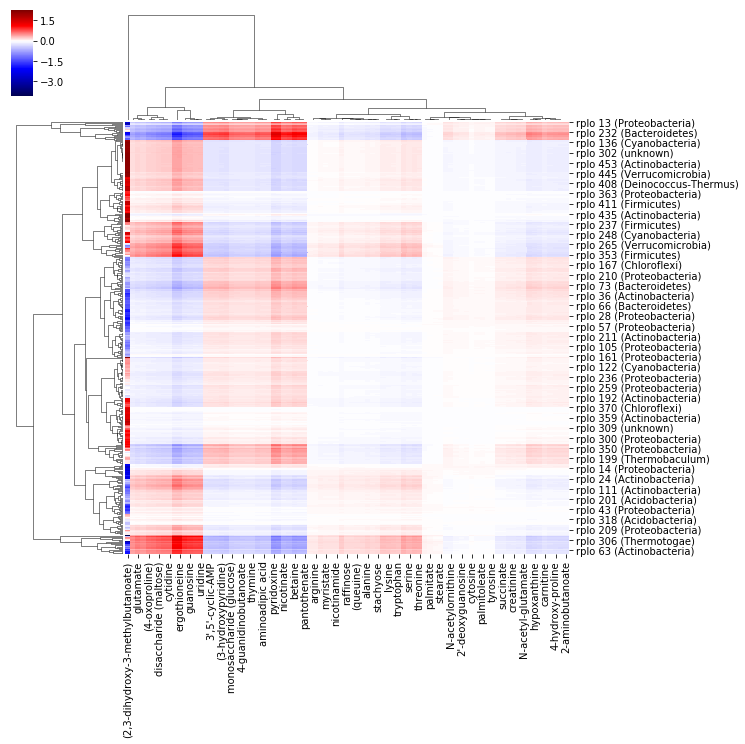

In [8]:
import seaborn as sns
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
_ = sns.clustermap(hm, cmap='seismic', norm=MidpointNormalize(midpoint=0.),)

# Construct plot of spearman coefficients vs conditional probabilities


In [9]:
!ls ../data

S1_metabolites_rev.xlsx        metabolites.biom
S4_rplo_genes_highlighted.xlsx microbes.biom


In [10]:
microbes = load_table('../data/microbes.biom')
metabolites = load_table('../data/metabolites.biom')
microbes = microbes.to_dataframe().T
metabolites = metabolites.to_dataframe().T

In [11]:
microbes, metabolites = microbes.align(metabolites, join='inner', axis=0)
cmicrobes = microbes.apply(lambda x: x / x.sum(), axis=1)
cmetabolites = metabolites.apply(lambda x: x / x.sum(), axis=1)

In [12]:
microbes.shape, metabolites.shape

((19, 466), (19, 85))

In [13]:
len(microbes.columns), len(metabolites.columns)

(466, 85)

In [14]:
spearman_coefs = pd.DataFrame(index=microbes.columns, columns=metabolites.columns)
spearman_pvals = pd.DataFrame(index=microbes.columns, columns=metabolites.columns)

for i in microbes.columns:
    for j in metabolites.columns:
        res = spearmanr(cmicrobes[i], cmetabolites[j])
        spearman_coefs.loc[i, j] = res[0]
        spearman_pvals.loc[i, j] = res[1]

In [15]:
# align axes
coefs, spearman_coefs = coefs.align(spearman_coefs, join='inner', axis=0)

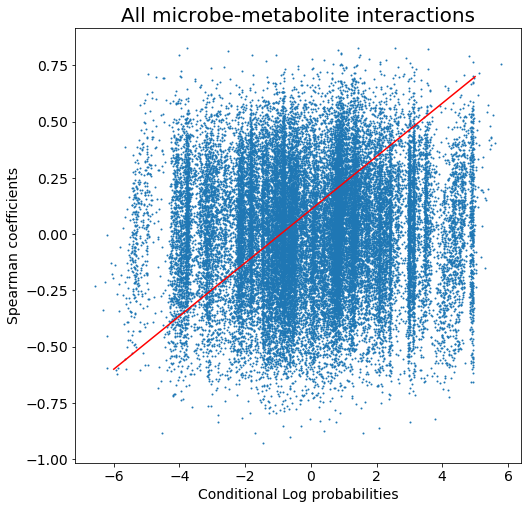

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(coefs.values.ravel(), spearman_coefs.values.ravel(), s=1)
ax.set_xlabel('Conditional Log probabilities', fontsize=14) 
ax.set_ylabel('Spearman coefficients', fontsize=14)

labelsize = 14
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
ax.plot(np.linspace(-6, 5), np.linspace(-.6, 0.7), '-r')

ax.set_title('All microbe-metabolite interactions', fontsize=20)
plt.savefig('../results/all_microbe_metabolite_interactions.png')

In [17]:
select_microbes = ['rplo 1 (Cyanobacteria)', 'rplo 2 (Firmicutes)', 
                   'rplo 60 (Firmicutes)', 'rplo 7 (Actinobacteria)']
microcoleus_metabolites = ['(3-methyladenine)', '7-methyladenine', '4-guanidinobutanoate', 'uracil',
                           'xanthine', 'hypoxanthine', '(N6-acetyl-lysine)', 'cytosine',
                           'N-acetylornithine', 'N-acetylornithine', 'succinate', 
                           'adenosine', 'guanine', 'adenine']

In [38]:
dxdy = pd.DataFrame(
    {
        '(3-methyladenine)': (-1.5, -0.1),
        '7-methyladenine': (0.5, -0.1),
        '4-guanidinobutanoate': (-2.1, -0.1),
        'uracil': (0.5, 0.1),
        'xanthine': (0, 0.1),
        'hypoxanthine': (0.2, -0.2),
        '(N6-acetyl-lysine)': (-1.7, 0.3),
        'cytosine': (0, 0.1),
        'N-acetylornithine': (0, -0.15),
        'succinate': (1., 0.1),
        'adenosine': (-1.2, 0.1),
        'guanine': (0.4, -0.2),
        'adenine': (-0.7, -0.2)
    }, index=['dx', 'dy']
).T

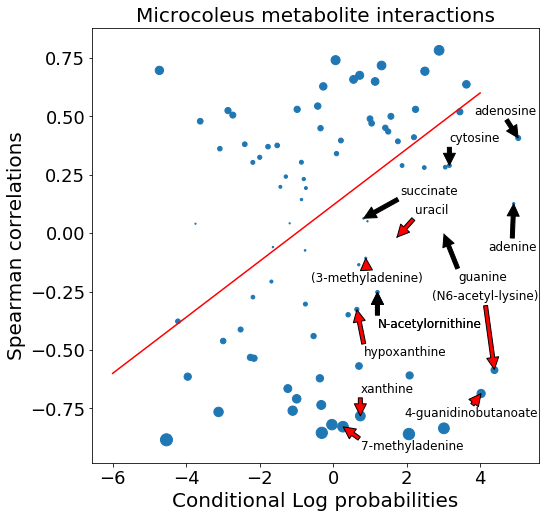

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
i = select_microbes[0]
ax.scatter(coefs.loc[i].values.ravel(), 
           spearman_coefs.loc[i].values.ravel(),             
           s=-10*np.log(spearman_pvals.loc[i].values.ravel().astype(np.float32)),
           label=i)

for j in microcoleus_metabolites:    
    dx = dxdy.loc[j, 'dx']
    dy = dxdy.loc[j, 'dy']
    
    x = coefs.loc[i, j]
    y = spearman_coefs.loc[i, j]
    if j in ['(3-methyladenine)', '7-methyladenine', '4-guanidinobutanoate', 'uracil',
             'xanthine', 'hypoxanthine', '(N6-acetyl-lysine)']:
        ax.annotate(j, xy=(x, y), xytext=(x+dx, y+dy), fontsize=12,
                    arrowprops=dict(facecolor='red', shrink=0.01))
    else:
        ax.annotate(j, xy=(x, y), xytext=(x+dx, y+dy), fontsize=12,
                    arrowprops=dict(facecolor='black', shrink=0.01))

ax.set_xlabel('Conditional Log probabilities', fontsize=20)
ax.set_ylabel('Spearman correlations', fontsize=20)
#ax.legend(loc=2, fontsize=12)
labelsize = 18
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
ax.plot(np.linspace(-6, 4), np.linspace(-.6, 0.6), '-r')

#ax.set_title(r'$\textit{Microcoleus}$ metabolite interactions', fontsize=20)
ax.set_title(r'Microcoleus metabolite interactions', fontsize=20)
plt.savefig('../results/microcoleus_metabolites.png')

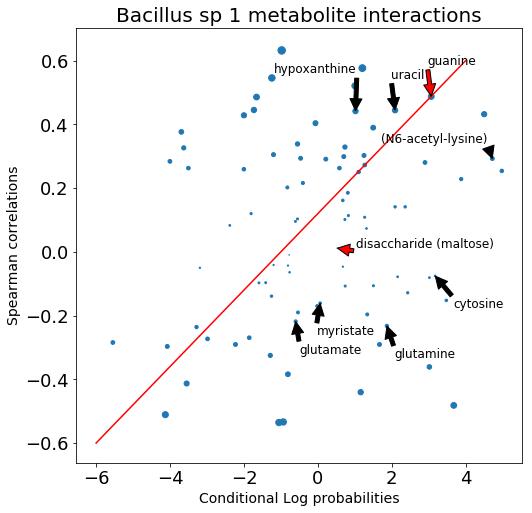

In [41]:
bacillus_1_metabolites = ['uracil', 'hypoxanthine', '(N6-acetyl-lysine)', 'cytosine',
                          'guanine', 'disaccharide (maltose)', 'glutamine', 
                          'myristate', 'glutamate']

dxdy = pd.DataFrame(
    {
        'uracil': (-.1, .1), 
        'hypoxanthine': (-2.2, 0.12), 
        '(N6-acetyl-lysine)': (-3.0, 0.05), 
        'cytosine': (.5, -.1),
        'guanine': (-.1, .1), 
        'adenine': (-1.2, -.15), 
        'disaccharide (maltose)': (.5, 0), 
        'glutamine': (.2, -.1), 
        'myristate': (-.1, -.1), 
        'glutamate': (0.1, -0.1)
    }, index=['dx', 'dy']
).T

fig, ax = plt.subplots(figsize=(8, 8))
i = select_microbes[1]
ax.scatter(coefs.loc[i].values.ravel(), 
           spearman_coefs.loc[i].values.ravel(), 
           s=-10*np.log(spearman_pvals.loc[i].values.ravel().astype(np.float32)),
           label=i)

for j in bacillus_1_metabolites:    
    dx = dxdy.loc[j, 'dx']
    dy = dxdy.loc[j, 'dy']
    
    x = coefs.loc[i, j]
    y = spearman_coefs.loc[i, j]
    if j in ['guanine', 'disaccharide (maltose)']:
        ax.annotate(j, xy=(x, y), xytext=(x+dx, y+dy), fontsize=12,
                    arrowprops=dict(facecolor='red', shrink=0.01))
    else:
        ax.annotate(j, xy=(x, y), xytext=(x+dx, y+dy), fontsize=12,
                    arrowprops=dict(facecolor='black', shrink=0.01))

ax.set_xlabel('Conditional Log probabilities', fontsize=20)
ax.set_ylabel('Spearman correlations', fontsize=20)
#ax.legend(loc=2, fontsize=12)
labelsize = 18
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
ax.plot(np.linspace(-6, 4), np.linspace(-.6, 0.6), '-r')

#ax.set_title(r'$\textit{Bacillus sp 1}\; $ metabolite interactions', fontsize=20)
ax.set_title(r'Bacillus sp 1 metabolite interactions', fontsize=20)

plt.savefig('../results/bacilus_sp_1_metabolites.png')

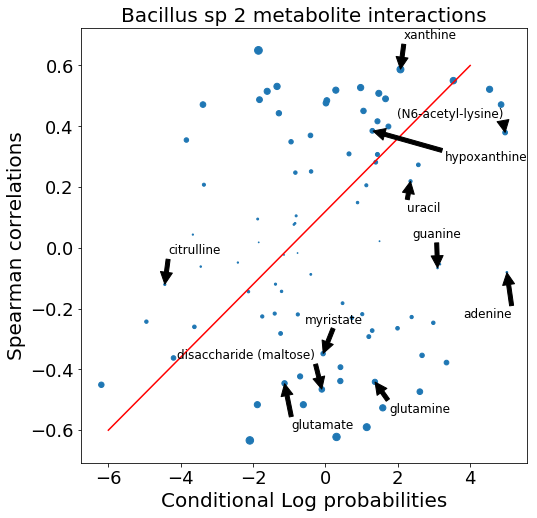

In [42]:
bacillus_2_metabolites = ['uracil', 'hypoxanthine', '(N6-acetyl-lysine)',
                          'guanine', 'adenine', 'disaccharide (maltose)', 'glutamine', 
                          'myristate', 'glutamate', 'xanthine', 'citrulline']

dxdy = pd.DataFrame(
    {
        'uracil': (-.1, -.1), 
        'hypoxanthine': (2., -0.1), 
        '(N6-acetyl-lysine)': (-3.0, 0.05), 
        'cytosine': (0.1, -.1),
        'guanine': (-.7, .1), 
        'adenine': (-1.2, -.15), 
        'disaccharide (maltose)': (-4., 0.1), 
        'glutamine': (.4, -.1), 
        'myristate': (-.5, .1), 
        'glutamate': (0.2, -0.15),
        'xanthine': (0.1, 0.1), 
        'citrulline': (0.1, 0.1)
    }, index=['dx', 'dy']
).T

fig, ax = plt.subplots(figsize=(8, 8))
i = select_microbes[2]
ax.scatter(coefs.loc[i].values.ravel(), 
           spearman_coefs.loc[i].values.ravel(), 
           s=-10*np.log(spearman_pvals.loc[i].values.ravel().astype(np.float32)),
           label=i)

for j in bacillus_2_metabolites:    
    dx = dxdy.loc[j, 'dx']
    dy = dxdy.loc[j, 'dy']
    
    x = coefs.loc[i, j]
    y = spearman_coefs.loc[i, j]
    ax.annotate(j, xy=(x, y), xytext=(x+dx, y+dy), fontsize=12,
                arrowprops=dict(facecolor='black', shrink=0.01))

ax.set_xlabel('Conditional Log probabilities', fontsize=20)
ax.set_ylabel('Spearman correlations', fontsize=20)
#ax.legend(loc=2, fontsize=12)
labelsize = 18
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
ax.plot(np.linspace(-6, 4), np.linspace(-.6, 0.6), '-r')
#ax.set_title(r'$\textit{Bacillus sp 2}\; $ metabolite interactions', fontsize=20)
ax.set_title(r'Bacillus sp 2 metabolite interactions', fontsize=20)
plt.savefig('../results/bacilus_sp_2_metabolites.png')

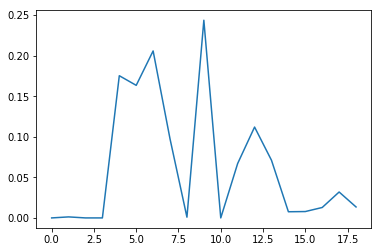

In [43]:
plt.plot(np.array(cmicrobes['rplo 2 (Firmicutes)'].values))

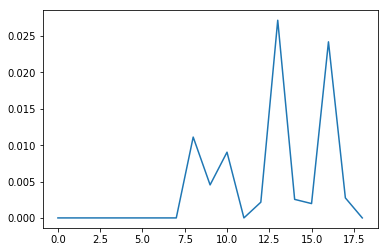

In [44]:
plt.plot(np.array(cmicrobes['rplo 60 (Firmicutes)'].values))

#TODO: Make 1 big subplot all of the plots

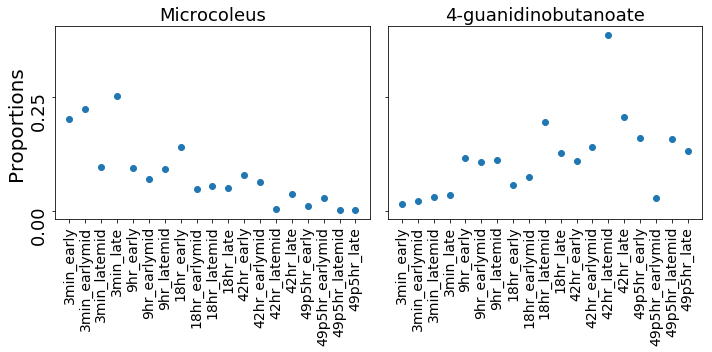

In [82]:
import matplotlib.ticker as ticker

rc('text', usetex=False)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].plot(np.array(cmicrobes['rplo 1 (Cyanobacteria)'].values),
         marker='o', linestyle='',label='Microcoleus')
ax[0].set_xticks(np.arange(len(cmicrobes.index)))
ax[0].set_xticklabels(list(cmicrobes.index))

ax[1].plot(np.array(cmetabolites['4-guanidinobutanoate'].values), 
         marker='o', linestyle='', label='4-guanidinobutanoate')
ax[1].set_xticks(np.arange(len(cmetabolites.index)))
ax[1].set_xticklabels(list(cmetabolites.index))
#ax[0].set_xticks([])

ax[0].tick_params(axis='x', rotation=90, labelsize=14)
ax[0].tick_params(axis='y', rotation=90, labelsize=18)
ax[1].tick_params(axis='x', rotation=90, labelsize=14)
ax[1].tick_params(axis='y', rotation=90, labelsize=14)

ax[0].yaxis.set_major_locator(ticker.MaxNLocator(2))
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(2))

ax[0].set_ylabel('Proportions', fontsize=20)

ax[0].set_title('Microcoleus', fontsize=18)
ax[1].set_title('4-guanidinobutanoate', fontsize=18)

#ax[0].legend()
plt.tight_layout()
plt.savefig('../results/microcoleus_proportions.png')